<a href="https://colab.research.google.com/github/SIDED00R/machinelearning/blob/main/machinelearning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn,optim
from torchvision import datasets,transforms

normalize=transforms.Normalize(mean=[x/255.0 for x in [125.3,123.0,113.9]],std=[x/255.0 for x in [63.0,62.1,66.7]])
batch_size=128
transform=transforms.Compose([transforms.ToTensor(),normalize])
train_dataset=datasets.CIFAR10('root/', train=True, transform=transform, download=True)
test_dataset=datasets.CIFAR10('root/', train=False, transform=transform, download=True)
trainloader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)
testloader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False,pin_memory=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting root/cifar-10-python.tar.gz to root/
Files already downloaded and verified


In [10]:
class BasicBlock(nn.Module):
  def __init__(self,in_channels,out_channels,ksize=3,stride=1,pad=1):
    super(BasicBlock,self).__init__()
    self.body=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,ksize,stride,pad),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    out=self.body(x)
    return out
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.b1=BasicBlock(3,32)
    self.b2=BasicBlock(32,32)
    self.maxpool=nn.MaxPool2d(2,2)
    self.dropout=nn.Dropout(0.25)
    self.b3=BasicBlock(32,64)
    self.b4=BasicBlock(64,64)
    self.linear1=nn.Linear(4096,512)
    self.linear2=nn.Linear(512,10)
  def forward(self,x):
    out=self.b1(x)
    out=self.b2(out)
    out=self.maxpool(out)
    out=self.dropout(out)
    out=self.b3(out)
    out=self.b4(out)
    out=self.maxpool(out)
    out=self.dropout(out)
    out=out.view(out.size(0),-1)
    out=self.linear1(out)
    out=self.dropout(out)
    out=self.linear2(out)
    return out
model=CNN().cuda()
criterion=nn.CrossEntropyLoss().cuda()
optimizer=optim.Adam(model.parameters(),lr=0.002)
epochs=5


In [11]:
t_accs,v_accs,t_loss,v_loss=[],[],[],[]
for epoch in range(epochs):
  train_loss=0
  train_accuracy=0
  model.train()

  for images,labels in trainloader:
    images=images.cuda()
    labels=labels.cuda()
    optimizer.zero_grad()
    output=model(images)
    # 로그 확률에 지수 적용
    ps = torch.exp(output) 
    # topk는 k번째로 큰 숫자를 찾아내는 것이다.
    # dim=1 는 dimension을 의미한다.
    top_p, top_class = ps.topk(1, dim = 1)
    # labels를 top_class와 똑같은 형태로 만든다음에, 얼마나 같은게 있는지 확인한다.
    equals = top_class == labels.view(*top_class.shape) 
    # equals를 float으로 바꾸고 평균 정확도를 구한다.
    train_accuracy += torch.mean(equals.type(torch.FloatTensor))

    loss=criterion(output,labels)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()

  t_accs.append(train_accuracy/len(trainloader))
  t_loss.append(train_loss/len(trainloader))

  test_loss=0
  test_accuracy=0
  model.eval()

  for images,labels in testloader:
    images=images.cuda()
    labels=labels.cuda()
    log_ps=model(images)
    test_loss+= criterion(log_ps,labels).item()

    ps=torch.exp(log_ps)
    top_p,top_class=ps.topk(1,dim=1)
    equals=top_class==labels.view(*top_class.shape)
    test_accuracy += torch.mean(equals.type(torch.FloatTensor))

  v_accs.append(test_accuracy/len(trainloader))
  v_loss.append(test_loss/len(trainloader))

  print("==> Epoch[{}/{}]".format(epoch+1, epochs))
  print("loss: {:.3f}, Accuracy: {:.3f}, val_loss: {:.3f}, val_accuracy: {:.3f}"
  .format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))

  model_out_path='./model.pth'
  torch.save(model.state_dict(),model_out_path)

==> Epoch[1/5]
loss: 1.551, Accuracy: 0.439, val_loss: 1.237, val_accuracy: 0.551
==> Epoch[2/5]
loss: 1.184, Accuracy: 0.577, val_loss: 1.063, val_accuracy: 0.623
==> Epoch[3/5]
loss: 1.038, Accuracy: 0.634, val_loss: 0.924, val_accuracy: 0.670
==> Epoch[4/5]
loss: 0.966, Accuracy: 0.659, val_loss: 0.841, val_accuracy: 0.706
==> Epoch[5/5]
loss: 0.917, Accuracy: 0.677, val_loss: 0.818, val_accuracy: 0.714


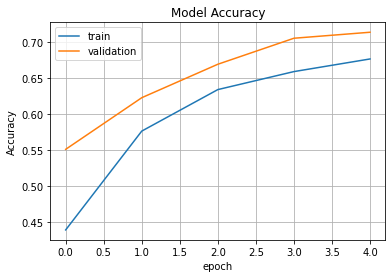

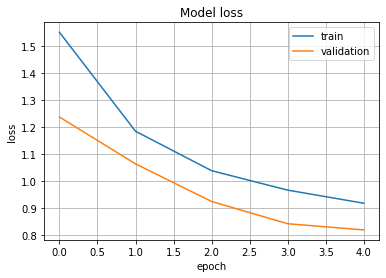

In [12]:
import matplotlib.pyplot as plt

plt.title('Model Accuracy')
plt.plot(t_accs,label='Training Accuracy')
plt.plot(v_accs,label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='best')
plt.grid()
plt.show()

plt.title('Model loss')
plt.plot(t_loss,label='Training loss')
plt.plot(v_loss,label='Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='best')
plt.grid()
plt.show()

In [ ]:
import torch
from torch.autograd import Function
from ..box_utils import decode, nms
from data import voc as cfg


class Detect(Function):
    """At test time, Detect is the final layer of SSD.  Decode location preds,
    apply non-maximum suppression to location predictions based on conf
    scores and threshold to a top_k number of output predictions for both
    confidence score and locations.
    """
    # PyTorch1.5.0 support new-style autograd function
    #def __init__(self, num_classes, bkg_label, top_k, conf_thresh, nms_thresh):
    #    self.num_classes = num_classes
    #    self.background_label = bkg_label
    #    self.top_k = top_k
    #    # Parameters used in nms.
    #    self.nms_thresh = nms_thresh
    #    if nms_thresh <= 0:
    #        raise ValueError('nms_threshold must be non negative.')
    #    self.conf_thresh = conf_thresh
    #    self.variance = cfg['variance']

    #def forward(self, loc_data, conf_data, prior_data):
    @staticmethod
    def forward(self, num_classes, bkg_label, top_k, conf_thresh, nms_thresh, loc_data, conf_data, prior_data):
        self.num_classes = num_classes
        self.background_label = bkg_label
        self.top_k = top_k
        # Parameters used in nms.
        self.nms_thresh = nms_thresh
        if nms_thresh <= 0:
            raise ValueError('nms_threshold must be non negative.')
        self.conf_thresh = conf_thresh
        self.variance = cfg['variance']
    # PyTorch1.5.0 support new-style autograd function
        """
        Args:
            loc_data: (tensor) Loc preds from loc layers
                Shape: [batch,num_priors*4]
            conf_data: (tensor) Shape: Conf preds from conf layers
                Shape: [batch*num_priors,num_classes]
            prior_data: (tensor) Prior boxes and variances from priorbox layers
                Shape: [1,num_priors,4]
        """
        num = loc_data.size(0)  # batch size
        num_priors = prior_data.size(0)
        # [バッチサイズN,クラス数21,トップ200件,確信度+位置]のゼロリストを作成
        output = torch.zeros(num, self.num_classes, self.top_k, 5)
        # 確信度を[バッチサイズN,クラス数,ボックス数]の順番に変更
        conf_preds = conf_data.view(num, num_priors,
                                    self.num_classes).transpose(2, 1)

        # Decode predictions into bboxes.
        for i in range(num):
            decoded_boxes = decode(loc_data[i], prior_data, self.variance)
            # For each class, perform nms
            conf_scores = conf_preds[i].clone()

            for cl in range(1, self.num_classes):
                # 確信度の閾値を使ってボックスを削除
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                scores = conf_scores[cl][c_mask]
                # handbook
                #if scores.dim() == 0:
                if scores.size(0) == 0:
                # handbook
                    continue
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # ボックスのデコード処理
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # idx of highest scoring and non-overlapping boxes per class
                # boxesからNMSで重複するボックスを削除
                ids, count = nms(boxes, scores, self.nms_thresh, self.top_k)
                output[i, cl, :count] = \
                    torch.cat((scores[ids[:count]].unsqueeze(1),
                               boxes[ids[:count]]), 1)
        flt = output.contiguous().view(num, -1, 5)
        _, idx = flt[:, :, 0].sort(1, descending=True)
        _, rank = idx.sort(1)
        flt[(rank < self.top_k).unsqueeze(-1).expand_as(flt)].fill_(0)
        return output

ImportError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# handbook
# from torch.autograd import Variable
# handbook
from layers import *
from data import voc, coco
import os


class SSD(nn.Module):
    """Single Shot Multibox Architecture
    The network is composed of a base VGG network followed by the
    added multibox conv layers.  Each multibox layer branches into
        1) conv2d for class conf scores
        2) conv2d for localization predictions
        3) associated priorbox layer to produce default bounding
           boxes specific to the layer's feature map size.
    See: https://arxiv.org/pdf/1512.02325.pdf for more details.
    Args:
        phase: (string) Can be "test" or "train"
        size: input image size
        base: VGG16 layers for input, size of either 300 or 500
        extras: extra layers that feed to multibox loc and conf layers
        head: "multibox head" consists of loc and conf conv layers
    """

    def __init__(self, phase, size, base, extras, head, num_classes):
        super(SSD, self).__init__()
        self.phase = phase
        self.num_classes = num_classes
        self.cfg = (coco, voc)[num_classes == 21]
        self.priorbox = PriorBox(self.cfg)
        # handbook
        # self.priors = Variable(self.priorbox.forward(), volatile=True)
        self.priors = self.priorbox.forward()
        # handbook
        self.size = size

        # SSD network
        self.vgg = nn.ModuleList(base)
        # Layer learns to scale the l2 normalized features from conv4_3
        self.L2Norm = L2Norm(512, 20)
        self.extras = nn.ModuleList(extras)
        # オフセットと確信度のネットワークリスト
        self.loc = nn.ModuleList(head[0])
        self.conf = nn.ModuleList(head[1])

        # demo実行時
        if phase == 'test':
            self.softmax = nn.Softmax(dim=-1)
            # PyTorch1.5.0 support new-style autograd function
            #self.detect = Detect(num_classes, 0, 200, 0.01, 0.45)
            self.detect = Detect()
            # PyTorch1.5.0 support new-style autograd function

    # 順伝播
    def forward(self, x):
        """Applies network layers and ops on input image(s) x.
        Args:
            x: input image or batch of images. Shape: [batch,3,300,300].
        Return:
            Depending on phase:
            test:
                Variable(tensor) of output class label predictions,
                confidence score, and corresponding location predictions for
                each object detected. Shape: [batch,topk,7]
            train:
                list of concat outputs from:
                    1: confidence layers, Shape: [batch*num_priors,num_classes]
                    2: localization layers, Shape: [batch,num_priors*4]
                    3: priorbox layers, Shape: [2,num_priors*4]
        """
        sources = list()
        loc = list()
        conf = list()

        # apply vgg up to conv4_3 relu
        for k in range(23):
            x = self.vgg[k](x)
        # Conv4-3>Reluの計算結果にL2Normを適用しsourcesに追加
        s = self.L2Norm(x)
        sources.append(s)

        # apply vgg up to fc7
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)
        # Conv7>Reluの計算結果をsourcesに追加
        sources.append(x)

        # 追加ネットワークにrelu関数を追加し順伝播
        # 奇数番目の層の計算結果をsourcesに追加
        # apply extra layers and cache source layer outputs
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:
                sources.append(x)

        # apply multibox head to source layers
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # (バッチサイズ,C,W,H) → (バッチサイズ,W,H,C)にTranspose
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)
        # demo実行時
        if self.phase == "test":
            # PyTorch1.5.0 support new-style autograd function
            #output = self.detect(
            output = self.detect.apply(self.num_classes, 0, 200, 0.01, 0.45,
            # PyTorch1.5.0 support new-style autograd function
                loc.view(loc.size(0), -1, 4),                   # loc preds
                self.softmax(conf.view(conf.size(0), -1,
                             self.num_classes)),                # conf preds
                self.priors.type(type(x.data))                  # default boxes
            )
        else:
        # train実行時
            output = (
                loc.view(loc.size(0), -1, 4),
                conf.view(conf.size(0), -1, self.num_classes),
                self.priors
            )
        return output

    def load_weights(self, base_file):
        other, ext = os.path.splitext(base_file)
        if ext == '.pkl' or '.pth':
            print('Loading weights into state dict...')
            self.load_state_dict(torch.load(base_file,
                                 map_location=lambda storage, loc: storage))
            print('Finished!')
        else:
            print('Sorry only .pth and .pkl files supported.')


# This function is derived from torchvision VGG make_layers()
# https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
# ベースネットワークのリスト作成
def vgg(cfg, i, batch_norm=False):
    layers = []
    in_channels = i
    for v in cfg:
        # プーリング層　300×300　→　150×150
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        # プーリング層で小数点切り上げ　75×75 →　38×38
        elif v == 'C':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return layers


# 追加ネットワークのリスト作成
def add_extras(cfg, i, batch_norm=False):
    # Extra layers added to VGG for feature scaling
    layers = []
    in_channels = i
    flag = False
    for k, v in enumerate(cfg):
        if in_channels != 'S':
            if v == 'S':
                # strideが2
                layers += [nn.Conv2d(in_channels, cfg[k + 1],
                           kernel_size=(1, 3)[flag], stride=2, padding=1)]
            else:
                layers += [nn.Conv2d(in_channels, v, kernel_size=(1, 3)[flag])]
            flag = not flag
        in_channels = v
    return layers

# オフセット、確信度のネットワークのリスト作成
def multibox(vgg, extra_layers, cfg, num_classes):
    loc_layers = []
    conf_layers = []
    vgg_source = [21, -2]
    # ベースの21のConv4-3と-2(最後から2番目)のConv7を特徴マップのリストに追加
    for k, v in enumerate(vgg_source):
        # 出力層の数はアスペクト比の数×座標数
        loc_layers += [nn.Conv2d(vgg[v].out_channels,
                                 cfg[k] * 4, kernel_size=3, padding=1)]
        # 出力層の数はアスペクト比の数×クラス数
        conf_layers += [nn.Conv2d(vgg[v].out_channels,
                        cfg[k] * num_classes, kernel_size=3, padding=1)]
    # 追加ネットの内、奇数番目の層を特徴マップのリストに追加
    for k, v in enumerate(extra_layers[1::2], 2):
        # 出力層の数はアスペクト比の数×座標数
        loc_layers += [nn.Conv2d(v.out_channels, cfg[k]
                                 * 4, kernel_size=3, padding=1)]
        # 出力層の数はアスペクト比の数×クラス数
        conf_layers += [nn.Conv2d(v.out_channels, cfg[k]
                                  * num_classes, kernel_size=3, padding=1)]
    return vgg, extra_layers, (loc_layers, conf_layers)

# 数字は入力チャンネル、M,Cはプーリング、Sはstride=2
base = {
    '300': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M',
            512, 512, 512],
    '512': [],
}
extras = {
    '300': [256, 'S', 512, 128, 'S', 256, 128, 256, 128, 256],
    '512': [],
}
# 特徴マップ毎のアスペクト比の数
mbox = {
    '300': [4, 6, 6, 6, 4, 4],  # number of boxes per feature map location
    '512': [],
}

# ネットワークのリスト作成
def build_ssd(phase, size=300, num_classes=21):
    if phase != "test" and phase != "train":
        print("ERROR: Phase: " + phase + " not recognized")
        return
    if size != 300:
        print("ERROR: You specified size " + repr(size) + ". However, " +
              "currently only SSD300 (size=300) is supported!")
        return
    # ベース、追加、オフセット、確信度のネットワークリストはクラスSSDの引数
    base_, extras_, head_ = multibox(vgg(base[str(size)], 3),
                                     add_extras(extras[str(size)], 1024),
                                     mbox[str(size)], num_classes)
    return SSD(phase, size, base_, extras_, head_, num_classes)